In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/elezhang/anaconda3/envs/jaxqtl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.4 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 pynndescent==0.5.8


In [2]:
pheno_path = "../../jaxqtl_project/data/OneK1K/pheno/OneK1K_cohort_gene_expression_matrix_14_celltypes.h5ad.gz"

In [23]:
mat = sc.read_h5ad(pheno_path)
mat

AnnData object with n_obs × n_vars = 1272489 × 32738
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent.mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age'
    var: 'GeneSymbol', 'features'

In [8]:
# check uniqueness of gene_id (ensembl_id)
mat.var
len(mat.var.index) == len(mat.var.index.unique())

True

In [9]:
mat.var # Geneid

,GeneSymbol,features
Geneid,,
ENSG00000243485,MIR1302-10,MIR1302-10
ENSG00000237613,FAM138A,FAM138A
ENSG00000186092,OR4F5,OR4F5
ENSG00000238009,RP11-34P13.7,RP11-34P13.7
ENSG00000239945,RP11-34P13.8,RP11-34P13.8
...,...,...
ENSG00000215635,AC145205.1,AC145205.1
ENSG00000268590,BAGE5,BAGE5
ENSG00000251180,CU459201.1,CU459201.1


normalizing counts per cell
    finished (0:00:52)


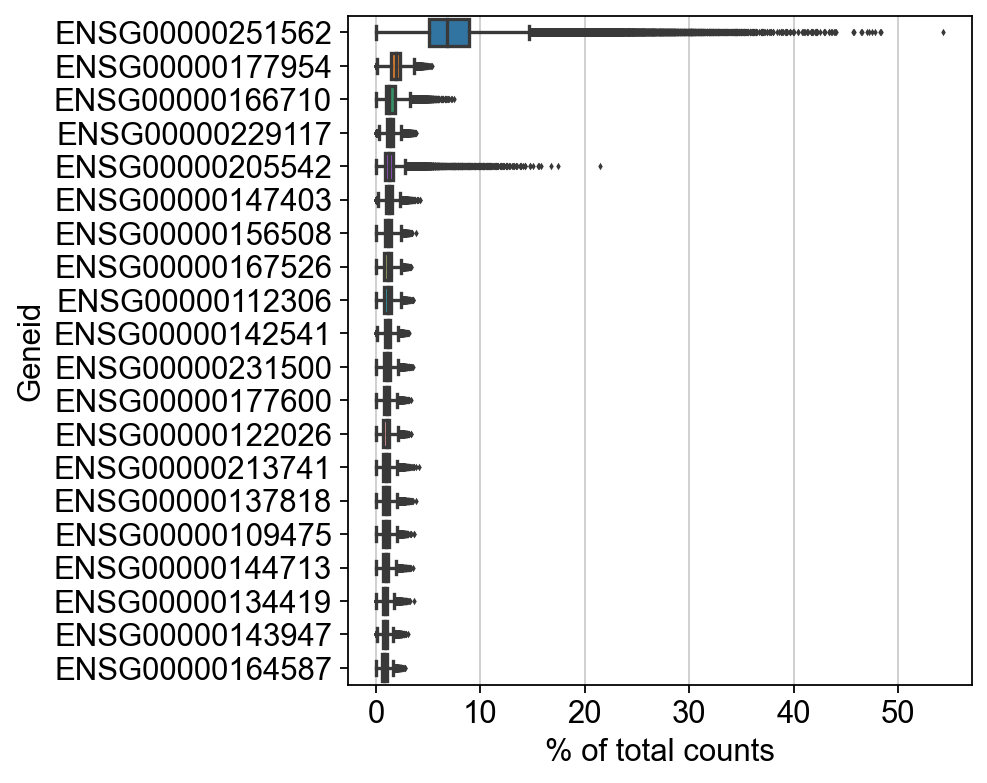

In [10]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells
sc.pl.highest_expr_genes(mat, n_top=20, )
# observe the "usual suspect" MALAT1 (ENSG00000251562)
# ref: https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.highest_expr_genes.html#scanpy.pl.highest_expr_genes

# Assess quality

In [ ]:
# doublet were removed in the raw dataset

## Cell count

In [38]:
# cell count per individual
cell_per_ind = mat.obs.groupby(['individual']).size().reset_index(name='counts')
cell_per_celltype_ind = mat.obs.groupby(['individual', 'cell_label']).size().reset_index(name='counts')
cell_per_celltype = mat.obs.groupby(['cell_label']).size().reset_index(name='counts')

count     981.000000
mean     1297.134557
std       323.487747
min       343.000000
25%      1096.000000
50%      1270.000000
75%      1468.000000
max      3523.000000
Name: counts, dtype: float64


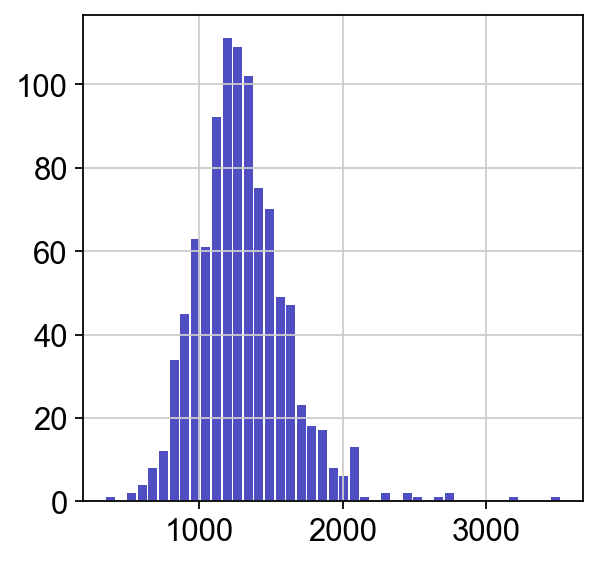

In [49]:
# cell count per individual
# The cell counts are determined by the number of unique cellular barcodes detected.
plt_n, plt_bins, plt_patches = plt.hist(x=cell_per_ind['counts'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
print(cell_per_ind.counts.describe())

<BarContainer object of 16 artists>

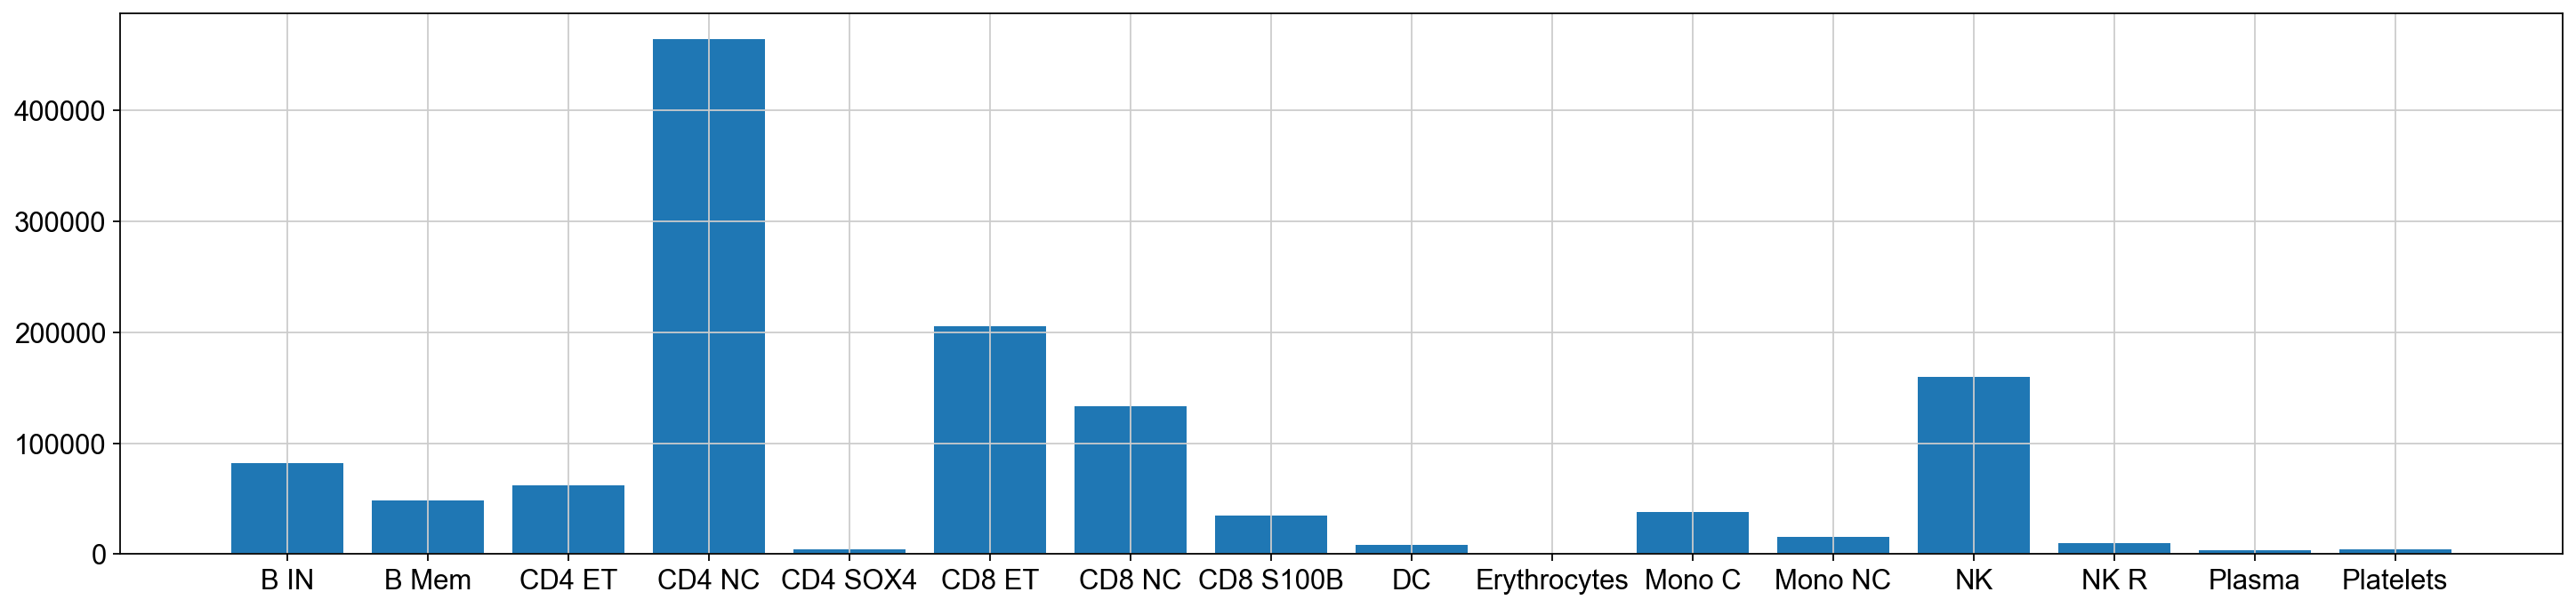

In [48]:
# cell count 
plt.figure(figsize=(22, 5))
plt.bar(cell_per_celltype['cell_label'], cell_per_celltype['counts'])

## UMI count per cell

count    1.272489e+06
mean     3.294681e+03
std      1.924958e+03
min      6.620000e+02
25%      1.996000e+03
50%      2.870000e+03
75%      4.110000e+03
max      8.289200e+04
Name: nCount_RNA, dtype: float64


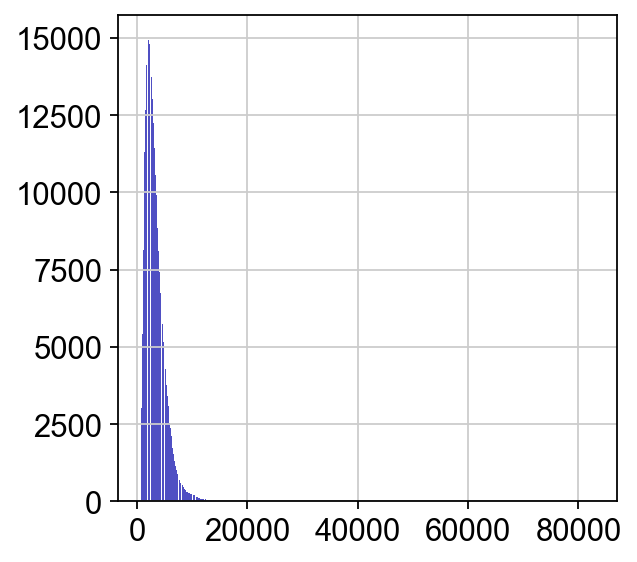

In [51]:
# expect > 500
print(mat.obs.nCount_RNA.describe()) 
plt_n, plt_bins, plt_patches = plt.hist(x=mat.obs['nCount_RNA'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

## Genes per cell

count    1.272489e+06
mean     9.159102e+02
std      3.655616e+02
min      1.030000e+02
25%      6.620000e+02
50%      8.540000e+02
75%      1.096000e+03
max      6.927000e+03
Name: nFeature_RNA, dtype: float64


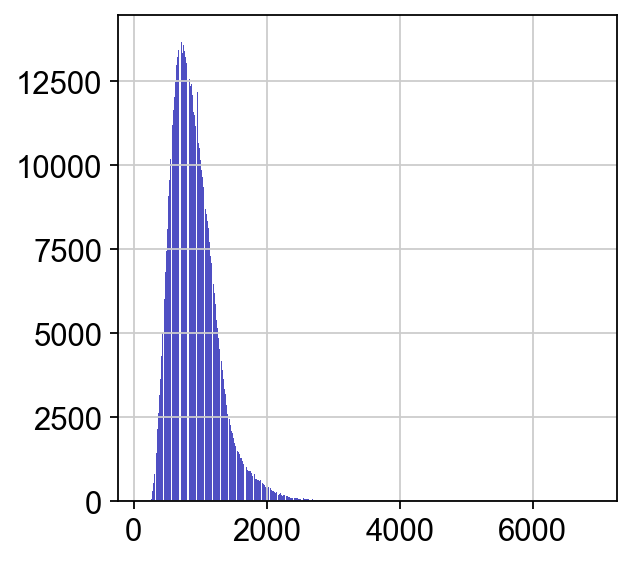

In [52]:
# number of genes expressed per cell > 100
# nFeature_RNA: the number of genes detected in each cell. 
# nCount_RNA: the total number of molecules (UMI) detected within a cell.
print(mat.obs.nFeature_RNA.describe()) 
plt_n, plt_bins, plt_patches = plt.hist(x=mat.obs['nFeature_RNA'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

## UMIs vs. Genes per cell

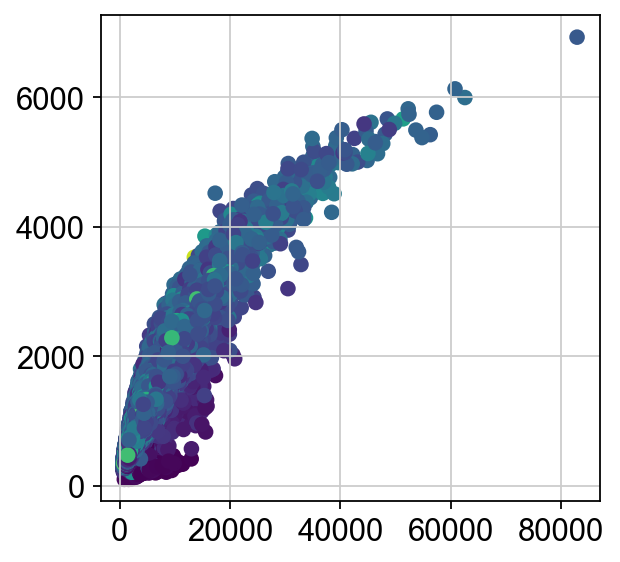

In [55]:
# poor quality are likely to have low genes and UMIs per cell
plt.scatter(mat.obs['nCount_RNA'], mat.obs['nFeature_RNA'], c=mat.obs['percent.mt'])

## Mitochondria count

count    1.272489e+06
mean     3.209758e+00
std      1.350741e+00
min      3.013258e-02
25%      2.252724e+00
50%      2.990773e+00
75%      3.929385e+00
max      1.093633e+01
Name: percent.mt, dtype: float64


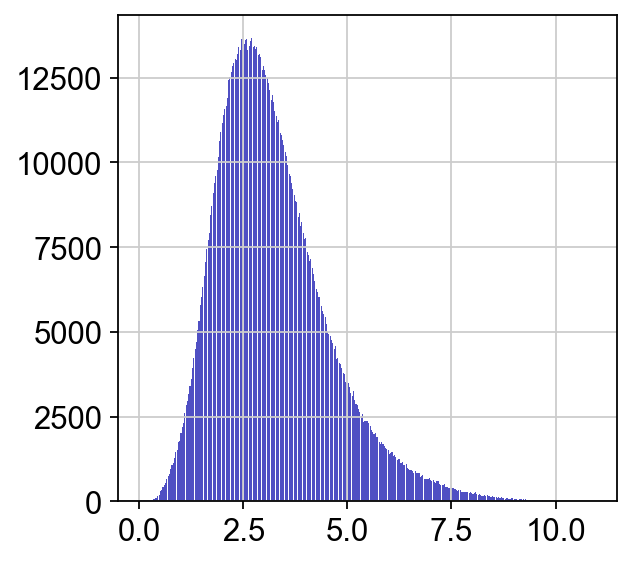

In [56]:
# This metric can identify whether there is a large amount of mitochondrial contamination from dead or dying cells.
# The threshold is usually 5%
print(mat.obs['percent.mt'].describe())
plt_n, plt_bins, plt_patches = plt.hist(x=mat.obs['percent.mt'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

## Complexity

In [60]:
# Add number of genes per UMI for each cell to metadata
log10GenesPerUMI = np.log10(mat.obs['nFeature_RNA']) / np.log10(mat.obs['nCount_RNA'])

count    1.272489e+06
mean     8.485380e-01
std      2.376609e-02
min      5.929372e-01
25%      8.307401e-01
50%      8.460643e-01
75%      8.648305e-01
max      9.392843e-01
dtype: float64


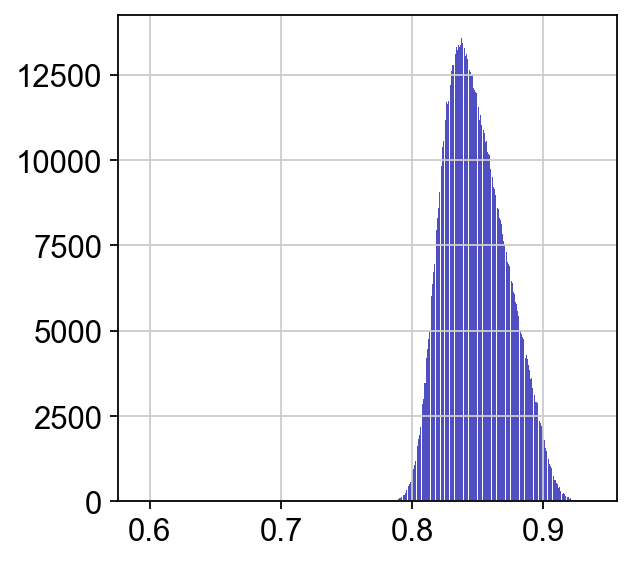

In [62]:
# Generally, we expect the novelty score to be above 0.80
print(log10GenesPerUMI.describe())
plt_n, plt_bins, plt_patches = plt.hist(x=log10GenesPerUMI, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

# Filtering

## Cell level

In [16]:
# Keep cells with >= 200 genes expressed
# sc.pp.filter_cells(mat, min_genes=200)

# Keep genes that are expressed in >= 3 cells
# sc.pp.filter_genes(mat, min_cells=3)

In [19]:
mat.var_names

Index(['ENSG00000243485', 'ENSG00000238009', 'ENSG00000239945',
       'ENSG00000241860', 'ENSG00000241599', 'ENSG00000286448',
       'ENSG00000229905', 'ENSG00000237491', 'ENSG00000177757',
       'ENSG00000228794',
       ...
       'ENSG00000198712', 'ENSG00000228253', 'ENSG00000198899',
       'ENSG00000198938', 'ENSG00000198840', 'ENSG00000212907',
       'ENSG00000198886', 'ENSG00000198786', 'ENSG00000198695',
       'ENSG00000198727'],
      dtype='object', name='ensembl_id', length=28891)

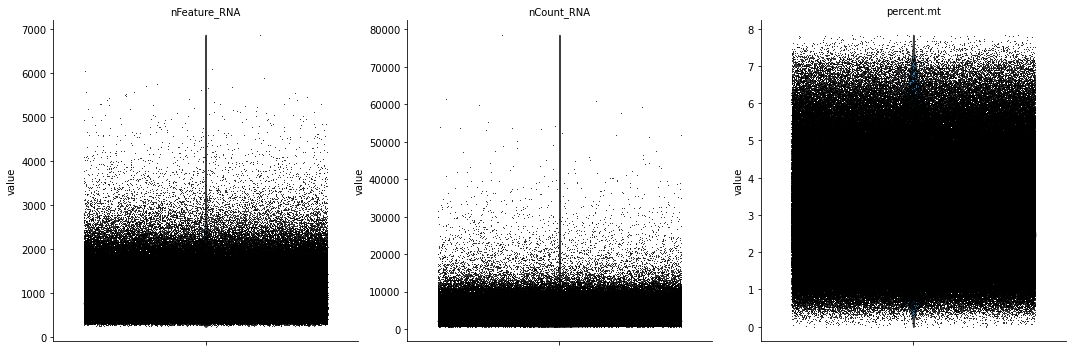

In [11]:
sc.pl.violin(mat, ['nFeature_RNA', 'nCount_RNA', 'percent.mt'],
             jitter=0.4, multi_panel=True)

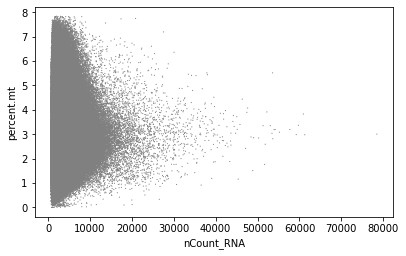

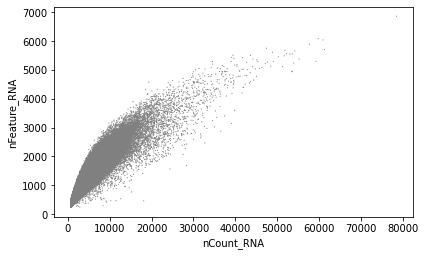

In [12]:
sc.pl.scatter(mat, x='nCount_RNA', y='percent.mt', size = 5)
sc.pl.scatter(mat, x='nCount_RNA', y='nFeature_RNA', size = 5)

In [ ]:
# sc.pp.filter_cells(mat, max_genes=5000)

In [ ]:
# mat = mat[mat.obs['percent.mt'] < 5]

### natural killer cell

In [ ]:
mat